In [1]:
import math
import numpy as np

import mido
import librosa
import librosa.display

import IPython.display as ipd
import matplotlib.pyplot as plt
from torch import optim

import torch.nn.functional as F
from torch import nn
import torch

windowSize=50

In [2]:
y, sr = librosa.load('4Beats2MelLong4.wav')

In [3]:
D = librosa.stft(y)

In [ ]:
librosa.display.waveplot(y, sr=sr);

In [4]:
midiArray=[]
HopSize=0.023
timeTracker=0.0
totalTimeTracker=0.0
MemoryArray=np.zeros(128)
lasttime=0;
bpm=60
for msg in mido.MidiFile('4Beats2MelLong4.mid'):
    if not msg.is_meta:
        totalTimeTracker+=msg.time
        nextEventTime=lasttime+msg.time
        while nextEventTime> timeTracker + HopSize:
            MemoryArray[127]=((timeTracker%4) * (bpm/60.0))/4.0
            midiArray.append(MemoryArray.copy())
            timeTracker += HopSize;
        if msg.type=='note_on':
            MemoryArray[msg.note]+=1.0;
        elif msg.type=='note_off':
            MemoryArray[msg.note]-=1.0;
        if(timeTracker+msg.time >= timeTracker + HopSize):
            MemoryArray[127]=((timeTracker%4) * (bpm/60.0))/4.0
            midiArray.append(MemoryArray.copy())
            timeTracker += HopSize
        lasttime += msg.time
    else:
        if(msg.type == 'set_tempo'):
            bpm=60000000/msg.tempo
        

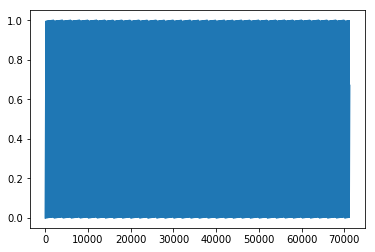

In [5]:
midiArray=np.float32(np.array(midiArray))


plt.plot(midiArray[:,127])
plt.show()

In [6]:
D_t=np.array(D.T)
minLength = min(midiArray.shape[0],D_t.real.shape[0])
#D_data=D_t[:minLength].real;

midiArray=midiArray[:minLength];


In [7]:
D_data=[]
for elem in D_t[:minLength]:
    temp=np.append(np.float32(elem.real),np.float32(elem.imag))
    D_data.append(temp)
D_data=np.array(D_data)

In [8]:
print(D_t.shape,midiArray.shape)
print(midiArray.shape,D_data.shape)
print(midiArray.dtype,D_data.dtype)

(70629, 1025) (70629, 128)
(70629, 128) (70629, 2050)
float32 float32


In [9]:

outPutMidiArray=[]
for i in range(midiArray.shape[0]):
    temp=[]
    for j in range(windowSize):
        val = int(j-(windowSize)) #int(j-(np.floor(windowSize/2))) #int(j-(windowSize)) 
        val = i+val
        if(val<0 or val+1>midiArray.shape[0]):
             temp.append(np.zeros(midiArray.shape[1]))
        else:
            temp.append(midiArray[val])
    outPutMidiArray.append(temp)
outPutMidiArray=np.array(outPutMidiArray)

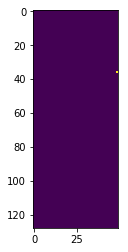

In [10]:
plt.imshow(outPutMidiArray[1].T)

In [83]:
## Solution

class Network(nn.Module):
    def __init__(self):
        super().__init__()
        # Defining the layers, 128, 64, 10 units each
        self.fc1 = nn.Linear(128*windowSize+2050, int(128*windowSize/2))
        #self.fc2 = nn.Linear(int(128*windowSize/2), int(128*windowSize/2))
        #self.fc3 = nn.Linear(int(128*windowSize/2), 3000)
        self.fc4 = nn.Linear(int(128*windowSize/2), 2050)
        self.first=True
        self.LastOutput = torch.zeros(2050)
    def forward(self, x):
        ''' Forward pass through the network, returns the output logits '''
        if(self.first):
            self.first=False
            print(str(x.shape)+"FirstRunInitWithZeros "+ str(self.LastOutput.shape))
            
        x = torch.cat((x,self.LastOutput),0)
        x = self.fc1(x)
        x = F.relu(x)
        #x = self.fc2(x)
        #x = F.relu(x)
        #x = self.fc3(x)
        #x = F.relu(x)
        x = self.fc4(x)
        x = F.relu(x)
        self.LastOutput = x
        print(self.LastOutput)
        return x

model = Network()
model

Network(
  (fc1): Linear(in_features=8450, out_features=3200, bias=True)
  (fc4): Linear(in_features=3200, out_features=2050, bias=True)
)

In [61]:
import torch.utils.data as utils


tensor_x = torch.stack([torch.Tensor(i) for i in np.abs(outPutMidiArray)]) # transform to torch tensors
tensor_y = torch.stack([torch.Tensor(i) for i in np.abs(D_data)])
tensor_x = tensor_x.view(tensor_x.shape[0],-1)
print(tensor_x.shape,tensor_y.shape)
my_dataset = utils.TensorDataset(tensor_x,tensor_y) # create your datset

train_size = int(0.8 * len(my_dataset))
test_size = len(my_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(my_dataset, [train_size, test_size])

my_dataloader = utils.DataLoader(train_dataset,batch_size=128,shuffle=False) # create your dataloader
my_validationloader = utils.DataLoader(test_dataset,batch_size=512,shuffle=False) # create your dataloader

print(len(my_dataloader),len(my_validationloader))

my_testloader = utils.DataLoader(my_dataset) # create your dataloader


# Optimizers require the parameters to optimize and a learning rate
optimizer = optim.SGD(model.parameters(), lr=0.01)

criterion = nn.MSELoss()
# or criterion = nn.MSELoss()
# Get our data


torch.Size([70629, 6400]) torch.Size([70629, 2050])
442 28


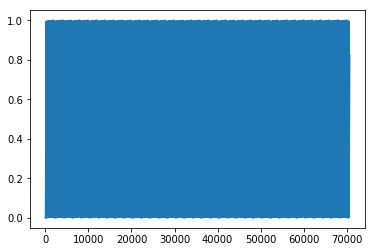

In [62]:
plt.plot(tensor_x.numpy()[:,127])
plt.show()

In [84]:
##Reset
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = 'cpu'
Counter=0;
LossOverEpoch=[]
EvalLoss=[]
model.train()
model.to(device)

Network(
  (fc1): Linear(in_features=8450, out_features=3200, bias=True)
  (fc4): Linear(in_features=3200, out_features=2050, bias=True)
)

In [85]:
epochs = 1000
for i in range(epochs):
    running_loss = 0
    model.train()
    for data, labels in my_dataloader:
        data, labels = data.to(device), labels.to(device)
        optimizer.zero_grad()     
        logits = model(data)
        loss =criterion(logits,labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    model.eval();
    evalLossNum=0
    for data, labels in my_validationloader:
        data, labels = data.to(device), labels.to(device)
        pred= model(data)
        loss = criterion(pred,labels)
        evalLossNum += loss.item()
    LossOverEpoch.append(running_loss)
    EvalLoss.append(evalLossNum)
    print(str(f"Training loss: {running_loss/len(my_dataloader)}" +"   "+ str(Counter))+"  "+str(evalLossNum/len(my_validationloader)))
    Counter+=1

torch.Size([128, 6400])FirstRunInitWithZeros torch.Size([2050])


RuntimeError: invalid argument 0: Tensors must have same number of dimensions: got 2 and 1 at /pytorch/aten/src/TH/generic/THTensorMoreMath.cpp:1298

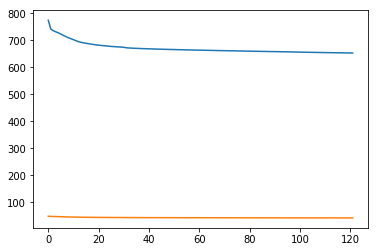

In [16]:
plt.plot(LossOverEpoch)
plt.plot(EvalLoss)
plt.show()
#torch.save(model.state_dict(), './w10-3270Epochs.model')

In [ ]:
model.eval()
outputArray=[]
for data, labels in my_testloader:
    with torch.no_grad():
        data, labels = data.to(device), labels.to(device)
        output = model.forward(data)
        outputArray.append(output[0].cpu().numpy())
outputArray=np.array(outputArray)

In [ ]:
plt.imshow(outputArray.T)
plt.tight_layout()

In [ ]:
transformedArray=[]
for elem in outputArray:
    a=np.array(1025 *[1+1j])
    a.real=elem[:1025]
    a.imag=elem[1025:]
    transformedArray.append(a)
transformedArray=np.array(transformedArray).T

In [ ]:
print((transformedArray).shape)
Y_infered = librosa.istft(transformedArray) 

In [ ]:
ipd.Audio(Y_infered,rate=sr)

In [ ]:
ipd.Audio(y,rate=sr)

In [ ]:

plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
librosa.display.specshow(librosa.amplitude_to_db(transformedArray.real,
                                                  ref=np.max),
                          y_axis='log', x_axis='time')
plt.title('Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()

plt.subplot(1,3,2)
librosa.display.specshow(librosa.amplitude_to_db(D.real,
                                                  ref=np.max),
                          y_axis='log', x_axis='time')
plt.title('Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()


plt.subplot(1,3,3)
librosa.display.specshow(librosa.amplitude_to_db(tensor_y.numpy()[:,:1025].T,
                                                  ref=np.max),
                          y_axis='log', x_axis='time')
plt.title('Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()


In [ ]:
output=np.array(0);
with torch.no_grad():
        test=torch.zeros([1, 128*windowSize], dtype=torch.float32)
       # test[0][46]=0.0;
        output = model.forward(test)
      #  test2=torch.ones([1, 1025], dtype=torch.float32)
      #  test2[0][46]=0.0;
        loss = criterion(output,torch.zeros([1, 1025], dtype=torch.float32))
        print(loss.item())
print(output.numpy()[0].shape,D_data[250].shape)
plt.plot(output.numpy()[0],'r')
#plt.plot(D_data[250],'g')
plt.show()

In [ ]:
plt.imshow(outPutMidiArray[60].T)
plt.show()

In [ ]:
midiTestArray=[]
HopSize=0.023
timeTracker=0.0
totalTimeTracker=0.0
MemoryArray=np.zeros(128)
lasttime=0;
bpm=60
for msg in mido.MidiFile('4Beats2Mel.mid'):
    if not msg.is_meta:
        totalTimeTracker+=msg.time
        nextEventTime=lasttime+msg.time
        while nextEventTime> timeTracker + HopSize:
            MemoryArray[127]=((timeTracker%4) * (bpm/60.0))/4.0
            midiTestArray.append(MemoryArray.copy())
            timeTracker += HopSize;
        if msg.type=='note_on':
            MemoryArray[msg.note]+=1.0;
        elif msg.type=='note_off':
            MemoryArray[msg.note]-=1.0;
        if(timeTracker+msg.time >= timeTracker + HopSize):
            MemoryArray[127]=((timeTracker%4) * (bpm/60.0))/4.0
            midiTestArray.append(MemoryArray.copy())
            timeTracker += HopSize
        lasttime += msg.time
    else:
        if(msg.type == 'set_tempo'):
            bpm=60000000/msg.tempo
midiTestArray = np.float32(np.array(midiTestArray))

MainMidiTest=[]
for i in range(midiTestArray.shape[0]):
    temp=[]
    for j in range(windowSize):
        val = int(j-(np.floor(windowSize/2)))
        val = i+val
        if(val<0 or val+1>midiTestArray.shape[0]):
             temp.append(np.zeros(midiTestArray.shape[1]))
        else:
            temp.append(midiTestArray[val])
    MainMidiTest.append(temp)
MainMidiTest=np.array(MainMidiTest)



tensor_x_test = torch.stack([torch.Tensor(i) for i in np.abs(MainMidiTest)])
tensor_x_test = tensor_x_test.view(tensor_x_test.shape[0],-1)

testDataSet = utils.TensorDataset(tensor_x_test,torch.zeros(tensor_x_test.shape)) # create your datset
TestLoader = utils.DataLoader(testDataSet) # create your dataloader


model.eval()
outputArray=[]
for data, labels in TestLoader:
    with torch.no_grad():
        output = model.forward(data)
        outputArray.append(output[0].numpy())
outputArray=np.array(outputArray).T
print((outputArray).shape)
Y_infered2 = librosa.istft(outputArray) 

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
librosa.display.specshow(librosa.amplitude_to_db(outputArray,
                                                  ref=np.max),
                          y_axis='log', x_axis='time')
plt.title('Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()

plt.subplot(1,2,2)
plt.imshow(midiTestArray.T,interpolation='nearest', aspect='auto')
plt.title('Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()

plt.show();


ipd.Audio(Y_infered2,rate=sr)

In [ ]:
librosa.display.waveplot(y[:500], sr=sr);